# Progetto Data Science su Time Series

#### Import

In [1]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import warnings
from pmdarima.arima import auto_arima
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima import acf
warnings.filterwarnings("ignore")

## ETL

#### Acquisizione dei dati nel dataframe "data"

In [2]:

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"


parte1 = pd.read_csv(datasets_path / 'deposits1.csv', sep=",")
parte2 = pd.read_csv(datasets_path / 'deposits2.csv', sep=",")
parte3 = pd.read_csv(datasets_path / 'deposits3.csv', sep=",")
parte4 = pd.read_csv(datasets_path / 'deposits4.csv', sep=",")
data = pd.concat([parte1, parte2, parte3, parte4], ignore_index=True)
data.head()

,id,id_location,passed_code,roll_id,access_code_id,consumer_id,waste_category_id,ecoisola_id,module_position,group_uniqid,quantity,weight,volume,pieces_count,ecoisola_authorization_mode,roll_exist,access_code_exist,consumer_exist,created_at,updated_at
0,87121,5,CAR0000000001002543,0,0,0,1,9,0,61cd903099a13,1,0,0,0,0,0,0,0,2021-12-30 10:55:33,2021-12-30 10:55:44
1,87122,5,SEC0000000001013417,38873,3447,7032,4,7,3,61cd9070c5789,1,0,0,0,2,1,1,1,2022-01-04 17:44:00,2022-01-04 17:44:00
2,87123,5,ORG0000000001008187,0,0,0,2,14,4,61cd914319432,1,0,0,0,0,0,0,0,2021-12-30 11:00:13,2021-12-30 11:00:19
3,87124,5,PLA0000000000033769,0,0,0,3,1,1,61cd916b9b572,1,0,0,0,0,0,0,0,2021-12-30 11:00:48,2021-12-30 11:00:59
4,87125,5,CMNCST53P57L049S,0,2274,4746,1,24,0,61cd91afb178c,1,0,0,0,1,0,1,1,2021-12-30 11:01:57,2021-12-30 11:02:07


#### Descrizione generale del dataset

In [3]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597307 entries, 0 to 597306
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   id                           597307 non-null  int64 
 1   id_location                  597307 non-null  int64 
 2   passed_code                  597307 non-null  object
 3   roll_id                      597307 non-null  int64 
 4   access_code_id               597307 non-null  int64 
 5   consumer_id                  597307 non-null  int64 
 6   waste_category_id            597307 non-null  int64 
 7   ecoisola_id                  597307 non-null  int64 
 8   module_position              597307 non-null  int64 
 9   group_uniqid                 597307 non-null  object
 10  quantity                     597307 non-null  int64 
 11  weight                       597307 non-null  int64 
 12  volume                       597307 non-null  int64 
 13  pieces_count  

#### Check valori nulli

In [4]:
data.isnull().sum()

id                             0
id_location                    0
passed_code                    0
roll_id                        0
access_code_id                 0
consumer_id                    0
waste_category_id              0
ecoisola_id                    0
module_position                0
group_uniqid                   0
quantity                       0
weight                         0
volume                         0
pieces_count                   0
ecoisola_authorization_mode    0
roll_exist                     0
access_code_exist              0
consumer_exist                 0
created_at                     0
updated_at                     0
dtype: int64

#### Drop colonne non utilizzate per l'analisi

In [5]:
lista_colonne = ["id_location", "passed_code", "roll_id", "access_code_id", "module_position", "group_uniqid","ecoisola_authorization_mode", "roll_exist", "access_code_exist", "consumer_exist","updated_at","quantity","weight","volume","pieces_count","consumer_id"]
data.drop(lista_colonne,axis = 1,inplace = True)
data.head()

,id,waste_category_id,ecoisola_id,created_at
0,87121,1,9,2021-12-30 10:55:33
1,87122,4,7,2022-01-04 17:44:00
2,87123,2,14,2021-12-30 11:00:13
3,87124,3,1,2021-12-30 11:00:48
4,87125,1,24,2021-12-30 11:01:57


#### Modifica sui valori numerici con rispettive etichette per le categorie di rifiuto

In [6]:
data['waste_category_id']=data['waste_category_id'].replace([1,2,3,4,5],['CARTA','ORGANICO','PLASTICA','SECCO','VETRO'])
data.head()

,id,waste_category_id,ecoisola_id,created_at
0,87121,CARTA,9,2021-12-30 10:55:33
1,87122,SECCO,7,2022-01-04 17:44:00
2,87123,ORGANICO,14,2021-12-30 11:00:13
3,87124,PLASTICA,1,2021-12-30 11:00:48
4,87125,CARTA,24,2021-12-30 11:01:57


#### Selezione plastic-ecoisola soggetta all'analisi

In [7]:
df_analisi = data[data['ecoisola_id']==29]
df_analisi.head()

,id,waste_category_id,ecoisola_id,created_at
29,87150,PLASTICA,29,2021-12-30 11:28:24
32,87153,PLASTICA,29,2021-12-30 11:34:09
38,87159,PLASTICA,29,2021-12-30 11:37:45
40,87161,PLASTICA,29,2021-12-30 11:39:29
41,87162,PLASTICA,29,2021-12-30 11:45:43


#### Convesione tipo colonna 'created_at'

In [8]:
df_analisi['created_at'] = pd.to_datetime(df_analisi['created_at'])
df_analisi.head()

,id,waste_category_id,ecoisola_id,created_at
29,87150,PLASTICA,29,2021-12-30 11:28:24
32,87153,PLASTICA,29,2021-12-30 11:34:09
38,87159,PLASTICA,29,2021-12-30 11:37:45
40,87161,PLASTICA,29,2021-12-30 11:39:29
41,87162,PLASTICA,29,2021-12-30 11:45:43


#### Selezione mese con più conferimenti

In [9]:
df_analisi = df_analisi[df_analisi['created_at'].dt.year == 2022]
df_analisi= df_analisi[df_analisi['created_at'].dt.month == 6]
df_analisi.head()

,id,waste_category_id,ecoisola_id,created_at
235748,324099,PLASTICA,29,2022-06-01 04:28:26
235773,324124,PLASTICA,29,2022-06-01 05:11:25
235776,324127,PLASTICA,29,2022-06-01 05:13:16
235778,324129,PLASTICA,29,2022-06-01 05:14:39
235785,324136,PLASTICA,29,2022-06-01 05:22:18


#### Drop Colonne ricavate implicitamente

In [10]:
df_analisi.drop(["ecoisola_id","id","waste_category_id"],axis=1, inplace = True)
df_analisi.head()

,created_at
235748,2022-06-01 04:28:26
235773,2022-06-01 05:11:25
235776,2022-06-01 05:13:16
235778,2022-06-01 05:14:39
235785,2022-06-01 05:22:18


#### Aggregazione conteggio conferimenti ogni quattro ore nel dataframe 'serie'

In [11]:
serie=df_analisi.groupby([pd.Grouper(key='created_at', freq='4H')]).size().reset_index(name='Conteggio')
serie

,created_at,Conteggio
0,2022-06-01 04:00:00,16
1,2022-06-01 08:00:00,14
2,2022-06-01 12:00:00,17
3,2022-06-01 16:00:00,6
4,2022-06-01 20:00:00,5
...,...,...
174,2022-06-30 04:00:00,25
175,2022-06-30 08:00:00,19
176,2022-06-30 12:00:00,18
177,2022-06-30 16:00:00,18


#### Ridenominazione colonna 'created_at' in Ora

In [12]:
serie.rename(columns={'created_at' : 'Ora'}, inplace=True)
serie.set_index('Ora', inplace = True)
serie=pd.Series(serie['Conteggio'])
serie

Ora
2022-06-01 04:00:00    16
2022-06-01 08:00:00    14
2022-06-01 12:00:00    17
2022-06-01 16:00:00     6
2022-06-01 20:00:00     5
                       ..
2022-06-30 04:00:00    25
2022-06-30 08:00:00    19
2022-06-30 12:00:00    18
2022-06-30 16:00:00    18
2022-06-30 20:00:00     7
Name: Conteggio, Length: 179, dtype: int64

## Costruzione modello di previsione

#### Plot serie 

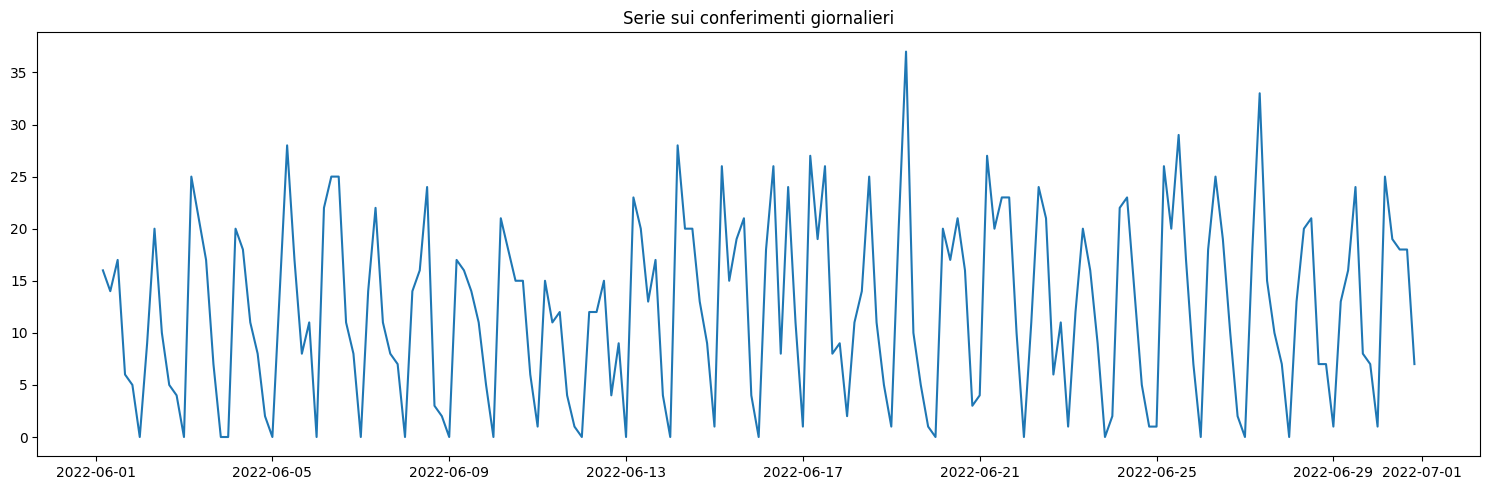

In [13]:
plt.figure(figsize=(15,5))
plt.plot(serie)
plt.title("Serie sui conferimenti giornalieri")
plt.tight_layout()

#### ADF 

In [14]:
result=adfuller(serie)
print ('ADF STATIC ------>%f' % result[0])
print ('P.Value ------>%f' % result[1])

ADF STATIC ------>-3.372046
P.Value ------>0.011950


#### Individuazione parametri p,q,d

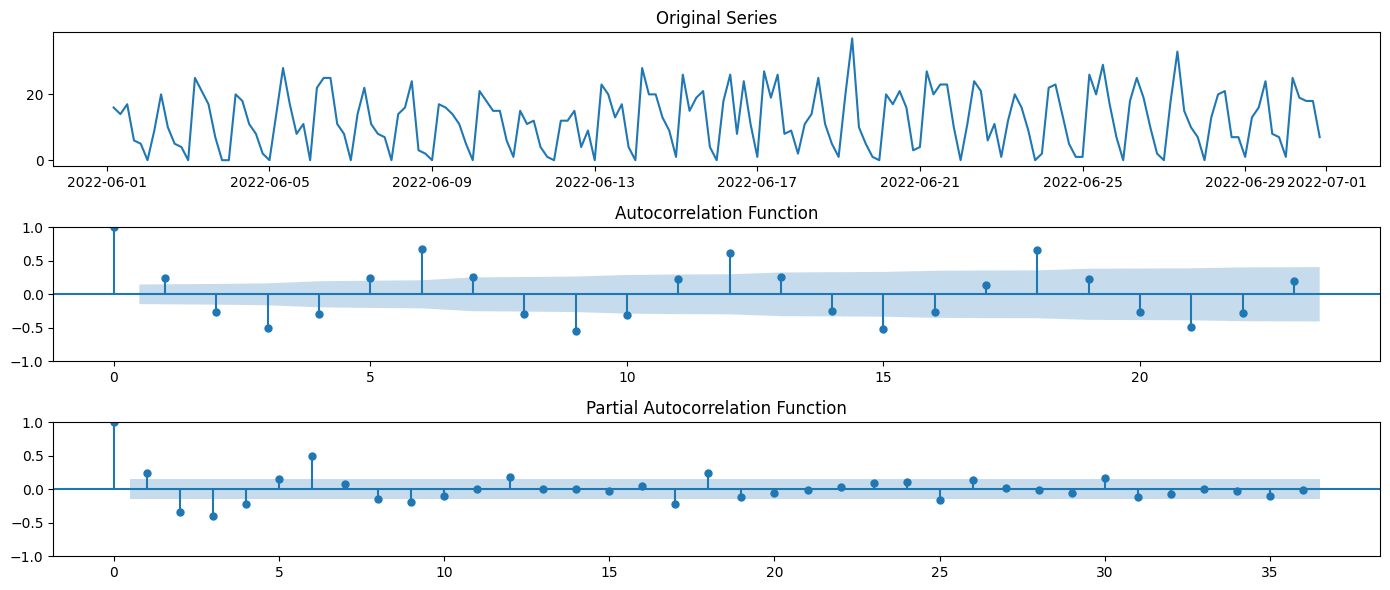

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(14, 6))
axes[0].plot(serie.dropna())
axes[0].set_title('Original Series')
plot_acf(serie, ax=axes[1])
axes[1].set_title('Autocorrelation Function')
plot_pacf(serie, ax=axes[2], lags=36, method="ywm")
axes[2].set_title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

## Parametri per ARIMA:
#### p 1|2|3|4
#### d = 0
#### q = 1|2|3|4

## Modello Arima(4,0,4)

#### summury

In [16]:
model = ARIMA(serie,order=(4,0,4))
print(model)
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Conteggio   No. Observations:                  179
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -568.002
Date:                Tue, 18 Jul 2023   AIC                           1156.003
Time:                        15:29:20   BIC                           1187.877
Sample:                    06-01-2022   HQIC                          1168.928
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2148      0.517     23.634      0.000      11.202      13.228
ar.L1         -0.6790      0.247     -2.749      0.006      -1.163      -0.195
ar.L2         -0.1364      0.070     -1.944      0.0

#### Diagnostica statsmodel

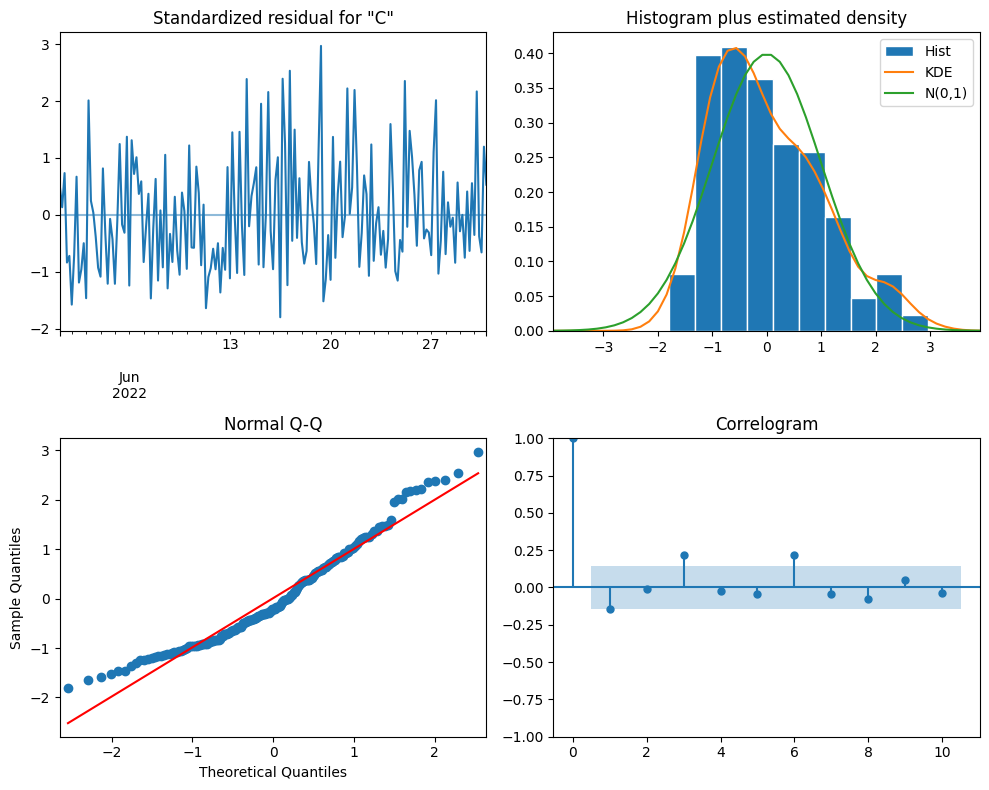

In [17]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

#### Predict del modello

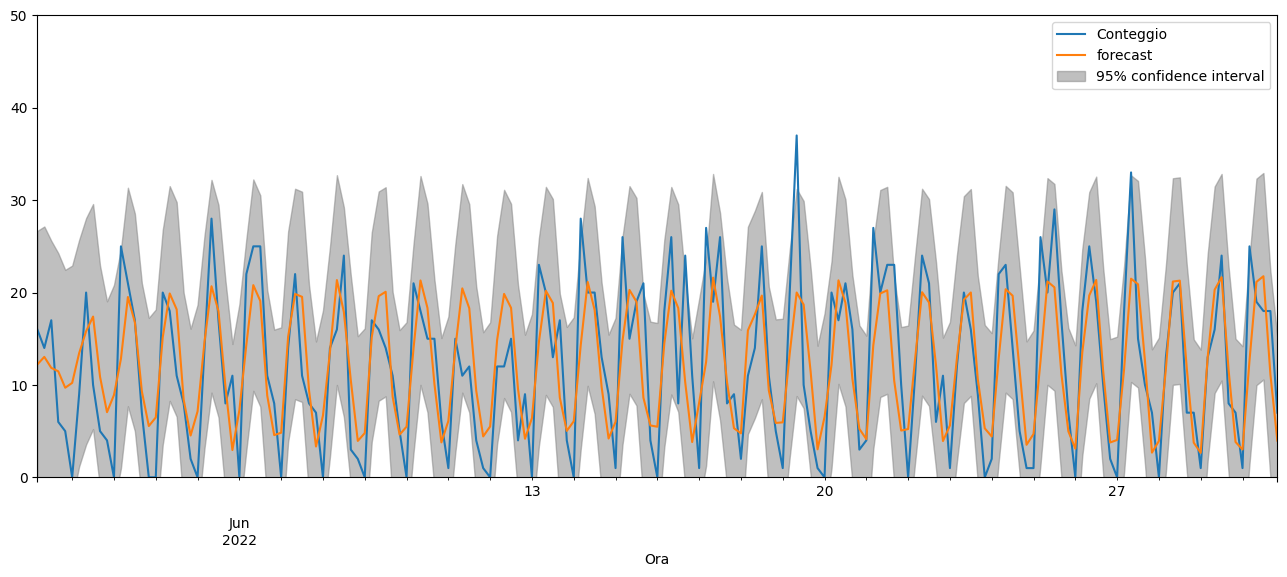

In [18]:
fig,ax = plt.subplots(figsize=(16,6))
ax = serie.plot(ax=ax)
plt.ylim(0,50)
plot_predict(model_fit,ax=ax, dynamic=False)
plt.plot()
plt.show()

#### Cross validation

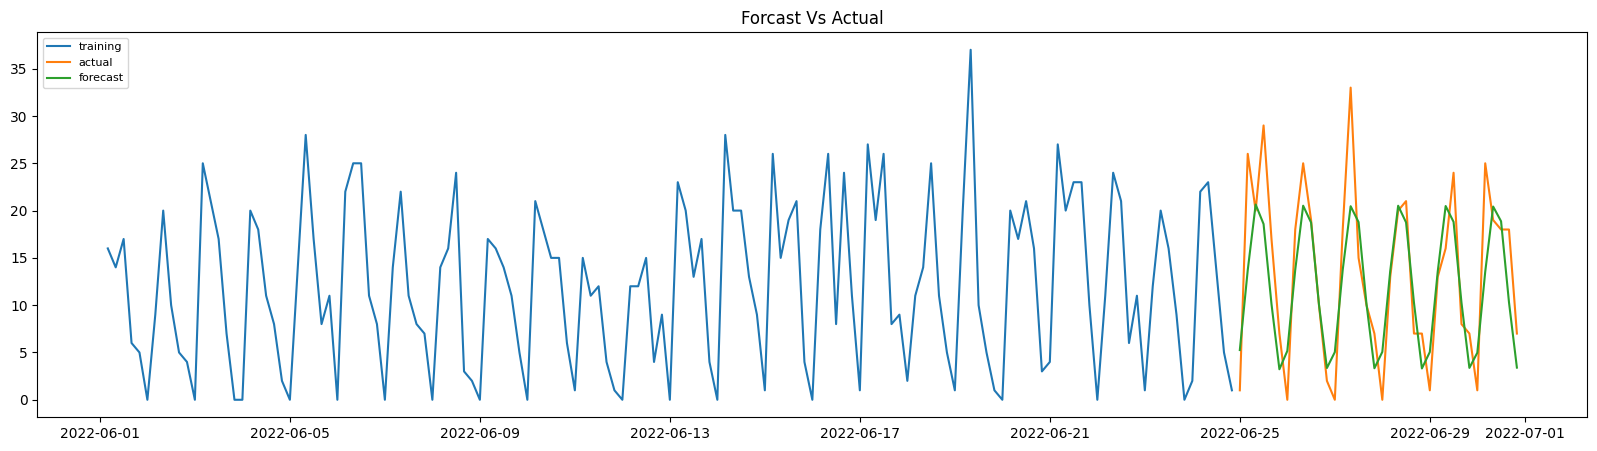

In [19]:
training_obs= int(len(serie)*0.8)
nobs = len(serie)
training_TS= serie[:training_obs]
test = serie[training_obs:]
model = ARIMA(training_TS,order=(4,0,4))
model_fit=model.fit()
fc =model_fit.forecast(36, alpha= 0.05)
plt.figure(figsize=(20,5))
plt.plot(training_TS,label='training')
plt.plot(test,label='actual')
plt.plot(fc,label='forecast')
plt.title('Forcast Vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Valori del forecast di un giorno

In [20]:
# Setup forecast

nforecasts= 7
forecasts={}
n_init_training = int(nobs*0.8)

#crea il modello

init_training_TS_mac= serie.iloc[:n_init_training]
mod =ARIMA(training_TS,order=(4,0,4))
res = mod.fit()
forecasts[training_TS.index[-1]]= res.forecast(steps=nforecasts)
for t in range(n_init_training,nobs):

    update_TS = serie.iloc[t:t+1]

    res = res.append(update_TS,refit=False)

    forecasts[update_TS.index[0]]=res.forecast(steps=nforecasts)

forecasts=pd.concat(forecasts,axis=1)

#previsioni successive

print(forecasts.iloc[:7,:7])

                     2022-06-24 20:00:00  2022-06-25 00:00:00  \
2022-06-25 00:00:00             5.255482                  NaN   
2022-06-25 04:00:00            13.708797            13.622696   
2022-06-25 08:00:00            20.646814            20.805245   
2022-06-25 12:00:00            18.576777            18.542496   
2022-06-25 16:00:00            10.120962            10.220685   
2022-06-25 20:00:00             3.225406             3.081589   
2022-06-26 00:00:00             5.167231             5.163271   

                     2022-06-25 04:00:00  2022-06-25 08:00:00  \
2022-06-25 00:00:00                  NaN                  NaN   
2022-06-25 04:00:00                  NaN                  NaN   
2022-06-25 08:00:00            21.054217                  NaN   
2022-06-25 12:00:00            18.081360            18.060186   
2022-06-25 16:00:00            10.321580            10.360737   
2022-06-25 20:00:00             2.792994             2.784247   
2022-06-26 00:00:00     

#### Errore forecast nelle ore del giorno

In [21]:
#errori previsioni

def flatten(column):

    return column.dropna().reset_index(drop=True)




flattened= forecasts.apply(lambda column:serie-column).reindex(forecasts.index).apply(flatten)

flattened.index = (flattened.index+1).rename('Indice Ora')




print(flattened.iloc[:7,:7])

            2022-06-24 20:00:00  2022-06-25 00:00:00  2022-06-25 04:00:00  \
Indice Ora                                                                  
1                     -4.255482            12.377304            -1.054217   
2                     12.291203            -0.805245            10.918640   
3                     -0.646814            10.457504             6.678420   
4                     10.423223             6.779315             4.207006   
5                      6.879038             3.918411            -5.581906   
6                      3.774594            -5.163271             4.295448   
7                     -5.167231             4.305791             4.280317   

            2022-06-25 08:00:00  2022-06-25 12:00:00  2022-06-25 16:00:00  \
Indice Ora                                                                  
1                     10.939814             6.419277             4.493403   
2                      6.639263             4.621771            -5.458883  

In [22]:
def forecast_accuracy(forecast,actual):
    
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))

    me = np.mean(forecast-actual)

    mae= np.mean(np.abs(forecast-actual))

    mpe= np.mean((forecast-actual)/actual)

    rmse= np.mean((forecast - actual)**2)**.5    

    corr= np.corrcoef(forecast,actual)[0,1]

    mins= np.amin(np.hstack([forecast[:,None],

                             actual[:,None]]),axis=1)

    maxs= np.amax(np.hstack([forecast[:,None],

                             actual[:,None]]),axis=1)

    minmax= 1-np.mean(mins/maxs)

    acf1=acf(fc-test)[1]

    return({'mape':mape,'me':me,'mae':mae,

           'mpe':mpe, 'rmse':rmse,'acf1':acf1,

           'corr':corr,'minmax':minmax})

forecast_accuracy(fc,test.values)

{'mape': inf,
 'me': -1.4677668454595734,
 'mae': 4.107126387900773,
 'mpe': inf,
 'rmse': 5.256761968581231,
 'acf1': -0.24312608651360892,
 'corr': 0.8366998457494642,
 'minmax': 0.3657136062147325}

#### Calcolo valore medio

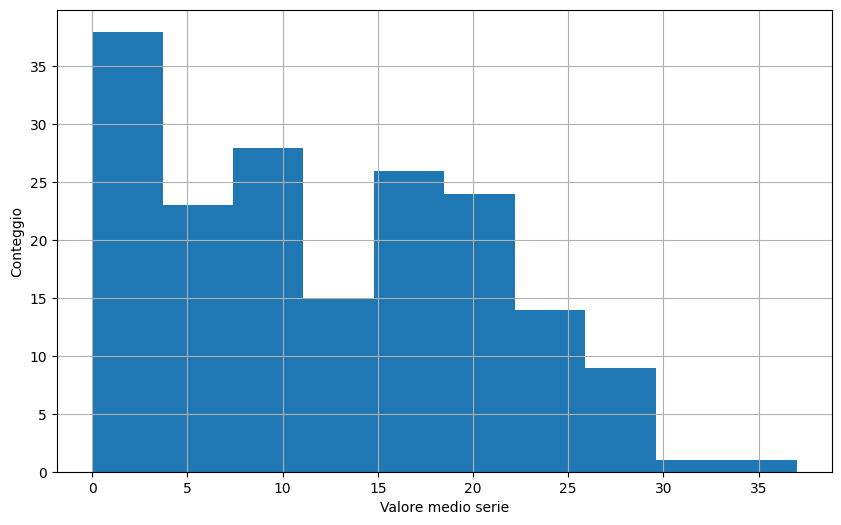

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax=serie.hist()

ax.set_xlabel('Valore medio serie')

ax.set_ylabel('Conteggio')

plt.show()

## Costruzione modello con la funzione autoarima

#### Summary modello calcolato con autoarima

In [24]:
# Utilizzo il modello con funzione autoarima


import pmdarima as pm
model_prova = pm.auto_arima(serie, start_p=0, start_q=0,

                      test='adf',

                      max_p=3, max_q=3,

                      m=1,

                      d=None,

                      seasonal=False,

                      start_P=0,

                      D=0,

                      trace=True,

                      error_action='ignore',

                      suppress_warnings=True,

                      stepwise=True)




print(model_prova.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1480.110, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1337.279, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1393.505, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1339.006, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1338.824, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1277.132, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1285.869, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1256.405, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1226.913, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1224.978, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1237.907, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1265.3

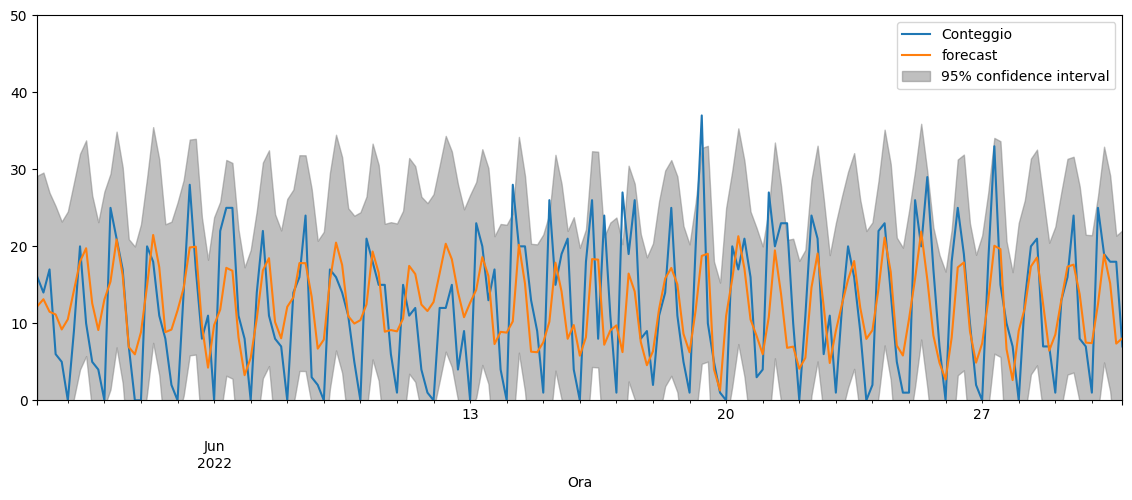

In [25]:
model_C_autoarima = ARIMA(serie,order=(3,0,1))
model_C_autoarima_fit= model_C_autoarima.fit()
fig,ax = plt.subplots(figsize=(14,5))
ax = serie.plot(ax=ax)
plt.ylim(0,50)
plot_predict(model_C_autoarima_fit,ax=ax, dynamic=False)
plt.show()

#### Diagnostica Arima

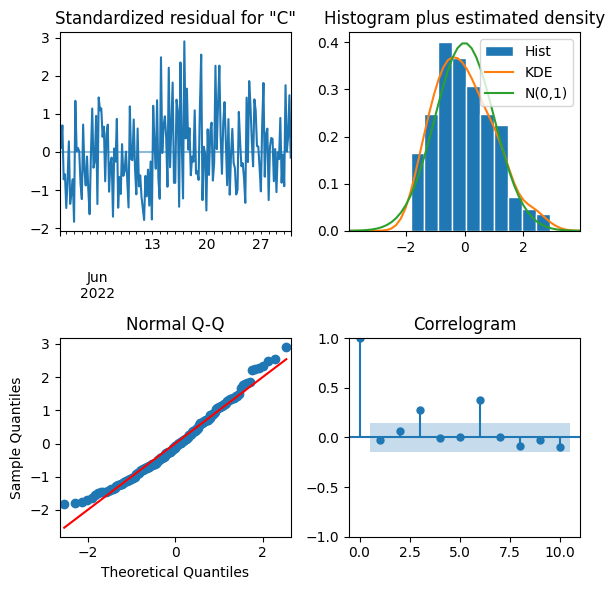

In [26]:
model_C_autoarima_fit.plot_diagnostics(figsize=(6, 6))
plt.tight_layout()
plt.show()

#### Cross validation modello calcolato con autoarima

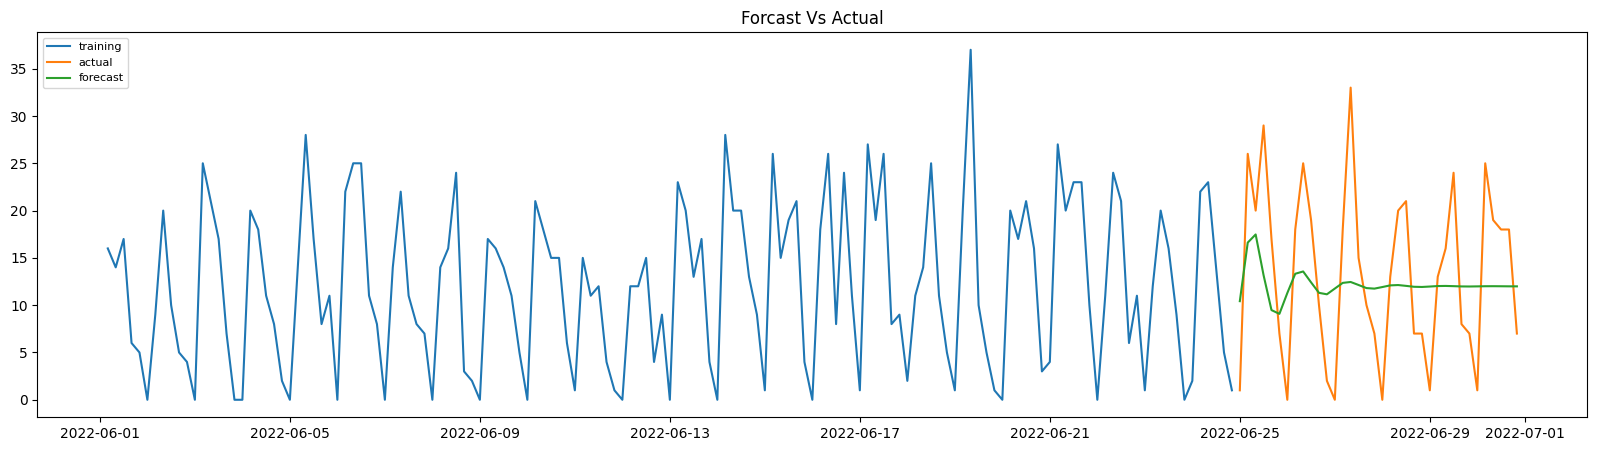

In [27]:
model_C_Autoarima = ARIMA(training_TS,order=(3,0,1))
model_C_Sarimax_Autoarima_fit= model_C_Autoarima.fit()
fc1 =model_C_Sarimax_Autoarima_fit.forecast(36, alpha= 0.05)
plt.figure(figsize=(20,5))
plt.plot(training_TS,label='training')
plt.plot(test,label='actual')
plt.plot(fc1,label='forecast')
plt.title('Forcast Vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
# Setup forecast

nforecasts= 7
forecasts={}
training_obs= int(len(serie)*0.8)
training_TS= serie[:training_obs]
nobs = len(serie)
n_init_training = int(nobs*0.8)

#crea il modello

init_training_TS_mac= serie.iloc[:n_init_training]
mod =ARIMA(training_TS,order=(3,0,1))
res = mod.fit()
forecasts[training_TS.index[-1]]= res.forecast(steps=nforecasts)
for t in range(n_init_training,nobs):

    update_TS = serie.iloc[t:t+1]

    res = res.append(update_TS,refit=False)

    forecasts[update_TS.index[0]]=res.forecast(steps=nforecasts)

forecasts=pd.concat(forecasts,axis=1)

#previsioni successive

print(forecasts.iloc[:7,:7])

                     2022-06-24 20:00:00  2022-06-25 00:00:00  \
2022-06-25 00:00:00            10.424394                  NaN   
2022-06-25 04:00:00            16.617148            15.247325   
2022-06-25 08:00:00            17.476750            19.572596   
2022-06-25 12:00:00            13.167563            17.206862   
2022-06-25 16:00:00             9.480552            10.768209   
2022-06-25 20:00:00             9.083028             7.785340   
2022-06-26 00:00:00            11.286263             9.220770   

                     2022-06-25 04:00:00  2022-06-25 08:00:00  \
2022-06-25 00:00:00                  NaN                  NaN   
2022-06-25 04:00:00                  NaN                  NaN   
2022-06-25 08:00:00            21.135483                  NaN   
2022-06-25 12:00:00            14.815625            14.650584   
2022-06-25 16:00:00             6.159609             6.412123   
2022-06-25 20:00:00             6.316199             6.802868   
2022-06-26 00:00:00     

In [29]:
def flatten(column):

    return column.dropna().reset_index(drop=True)




flattened= forecasts.apply(lambda column:serie-column).reindex(forecasts.index).apply(flatten)

flattened.index = (flattened.index+1).rename('index')




print(flattened.iloc[:7,:7])

       2022-06-24 20:00:00  2022-06-25 00:00:00  2022-06-25 04:00:00  \
index                                                                  
1                -9.424394            10.752675            -1.135483   
2                 9.382852             0.427404            14.184375   
3                 2.523250            11.793138            10.840391   
4                15.832437             6.231791             0.683801   
5                 7.519448            -0.785340           -10.701355   
6                -2.083028            -9.220770             3.100587   
7               -11.286263             5.457193             9.856529   

       2022-06-25 08:00:00  2022-06-25 12:00:00  2022-06-25 16:00:00  \
index                                                                  
1                14.349416             8.502207             2.152446   
2                10.587877             3.388231            -2.815566   
3                 0.197132            -4.706331             8.8

In [30]:
forecast_accuracy(fc1,test.values)

{'mape': inf,
 'me': -1.2338543940842106,
 'mae': 7.303964385327431,
 'mpe': inf,
 'rmse': 8.532128943138343,
 'acf1': -0.24312608651360892,
 'corr': 0.44761794769886376,
 'minmax': 0.4551394038280052}

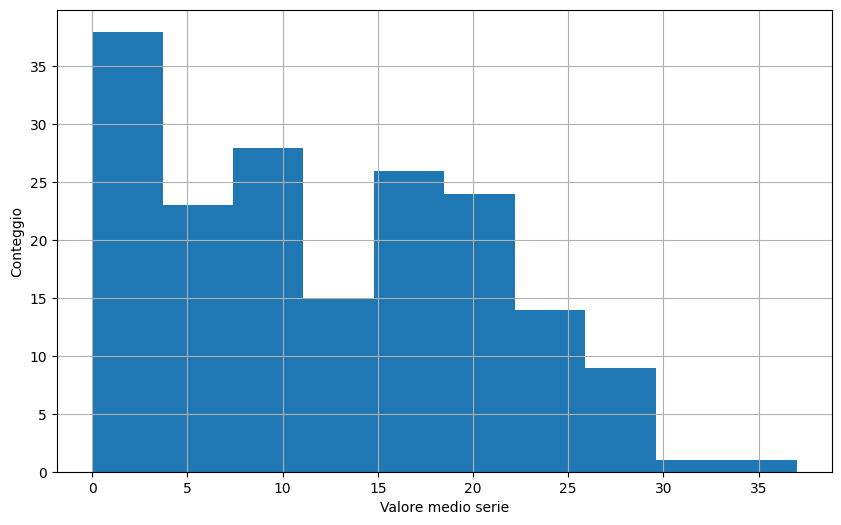

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

ax=serie.hist()

ax.set_xlabel('Valore medio serie')

ax.set_ylabel('Conteggio')

plt.show()

## Sarimax

In [32]:
import statsmodels.api as sm
mod_sarimax = sm.tsa.SARIMAX(serie, order=(4,0,4), seasonal_order=(3,0,1,6))
res_sarimax = mod_sarimax.fit()
print(res_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Conteggio   No. Observations:                  179
Model:             SARIMAX(4, 0, 4)x(3, 0, [1], 6)   Log Likelihood                -543.272
Date:                             Tue, 18 Jul 2023   AIC                           1112.544
Time:                                     15:29:32   BIC                           1153.980
Sample:                                 06-01-2022   HQIC                          1129.346
                                      - 06-30-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0664      0.133      7.991      0.000       0.805       1.328
ar.L2         -0.3229      

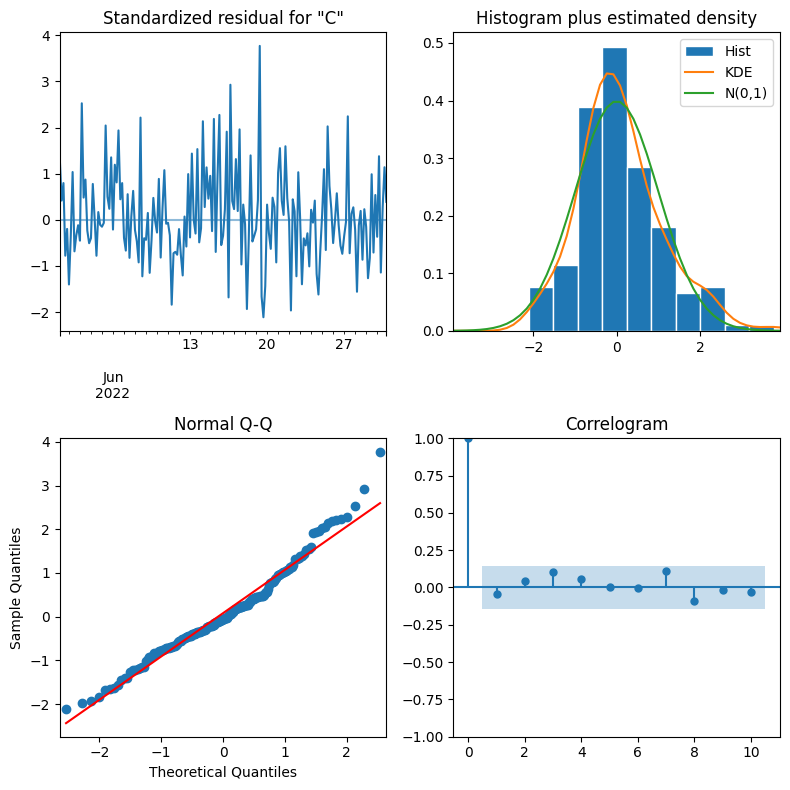

In [33]:
res_sarimax.plot_diagnostics(figsize=(8, 8))
plt.tight_layout()
plt.show()

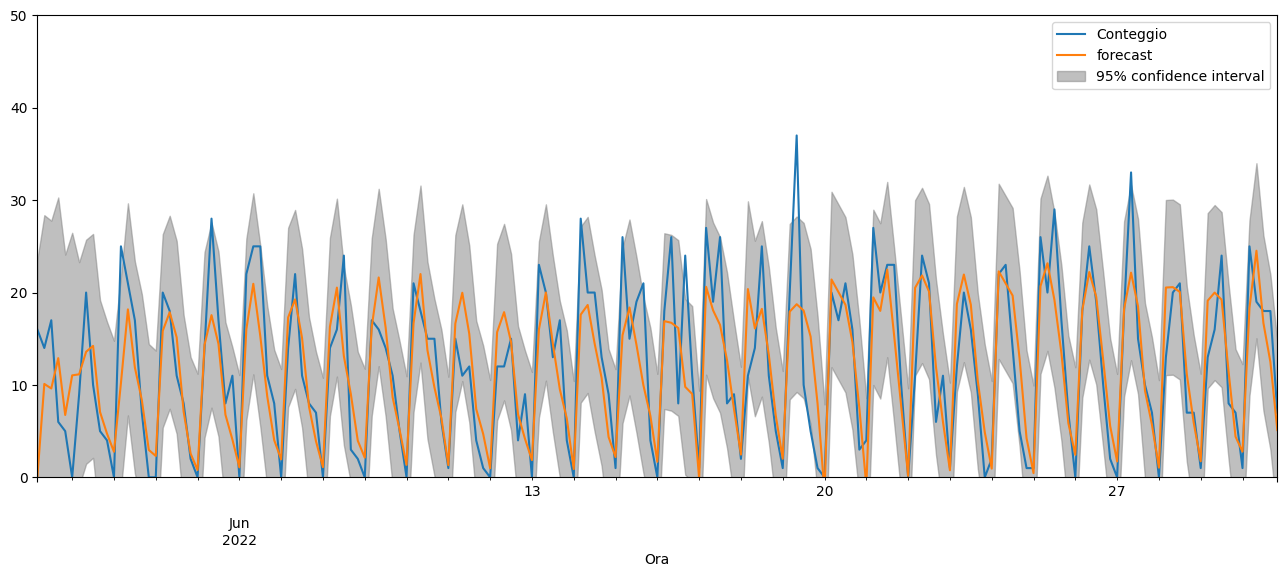

In [34]:
fig,ax = plt.subplots(figsize=(16,6))
ax = serie.plot(ax=ax)
plt.ylim(0,50)
plot_predict(res_sarimax,ax=ax, dynamic=False)
plt.plot()
plt.show()

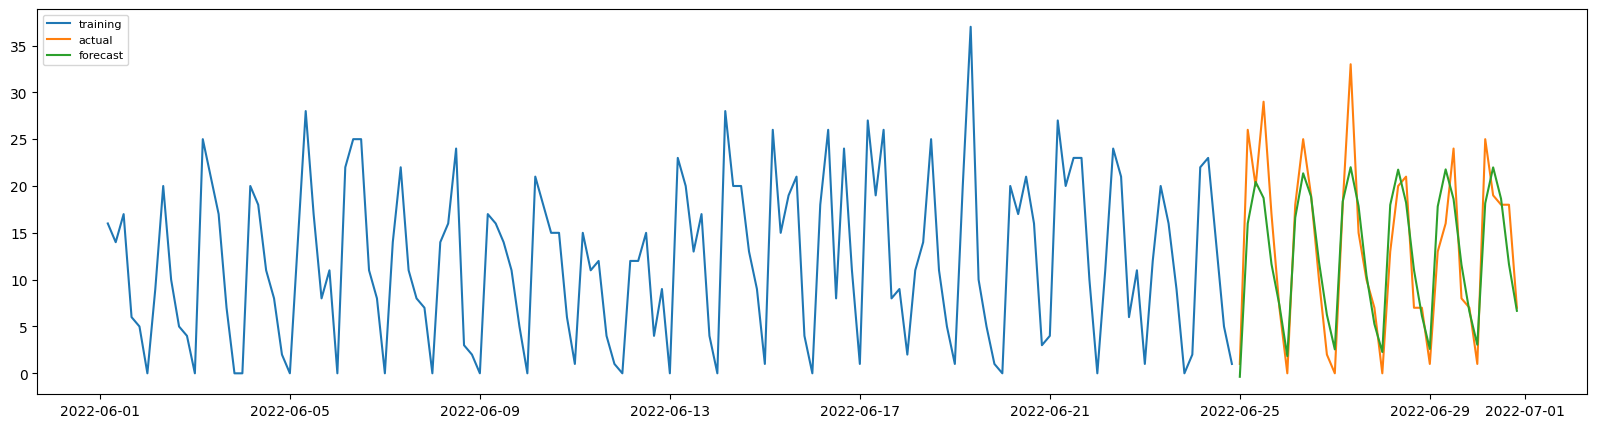

In [35]:
model_C_Sarimax = sm.tsa.SARIMAX(training_TS, order=(3,0,1), seasonal_order=(3,0,1,6),trend='t')
model_C_Sarimax_fit= model_C_Sarimax.fit()
fc2 =model_C_Sarimax_fit.forecast(36, alpha= 0.05)
plt.figure(figsize=(20,5))
plt.plot(training_TS,label='training')
plt.plot(test,label='actual')
plt.plot(fc2,label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### forecast

In [36]:
# Setup forecast

nforecasts= 7
forecasts={}
training_obs= int(len(serie)*0.8)
training_TS= serie[:training_obs]
nobs = len(serie)
n_init_training = int(nobs*0.8)

#crea il modello

init_training_TS_mac= serie.iloc[:n_init_training]
mod =sm.tsa.SARIMAX(training_TS, order=(3,0,1), seasonal_order=(3,0,1,6),trend='t')
res = mod.fit()
forecasts[training_TS.index[-1]]= res.forecast(steps=nforecasts)
for t in range(n_init_training,nobs):

    update_TS = serie.iloc[t:t+1]

    res = res.append(update_TS,refit=False)

    forecasts[update_TS.index[0]]=res.forecast(steps=nforecasts)

forecasts=pd.concat(forecasts,axis=1)

#previsioni successive

print(forecasts.iloc[:7,:7])

                     2022-06-24 20:00:00  2022-06-25 00:00:00  \
2022-06-25 00:00:00            -0.369611                  NaN   
2022-06-25 04:00:00            16.004711            16.175977   
2022-06-25 08:00:00            20.436222            20.589814   
2022-06-25 12:00:00            18.720051            19.003987   
2022-06-25 16:00:00            11.661629            11.754906   
2022-06-25 20:00:00             7.284752             7.353713   
2022-06-26 00:00:00             1.833963             2.013598   

                     2022-06-25 04:00:00  2022-06-25 08:00:00  \
2022-06-25 00:00:00                  NaN                  NaN   
2022-06-25 04:00:00                  NaN                  NaN   
2022-06-25 08:00:00            21.818280                  NaN   
2022-06-25 12:00:00            20.105683            19.878312   
2022-06-25 16:00:00            13.791538            13.587631   
2022-06-25 20:00:00             8.022770             7.645820   
2022-06-26 00:00:00     

In [37]:
def flatten(column):

    return column.dropna().reset_index(drop=True)




flattened= forecasts.apply(lambda column:serie-column).reindex(forecasts.index).apply(flatten)

flattened.index = (flattened.index+1).rename('index')




print(flattened.iloc[:7,:7])

       2022-06-24 20:00:00  2022-06-25 00:00:00  2022-06-25 04:00:00  \
index                                                                  
1                 1.369611             9.824023            -1.818280   
2                 9.995289            -0.589814             8.894317   
3                -0.436222             9.996013             3.208462   
4                10.279949             5.245094            -1.022770   
5                 5.338371            -0.353713            -2.508244   
6                -0.284752            -2.013598             0.037277   
7                -1.833963             1.325778             3.260737   

       2022-06-25 08:00:00  2022-06-25 12:00:00  2022-06-25 16:00:00  \
index                                                                  
1                 9.121688             2.271728            -1.952826   
2                 3.412369            -1.668753            -4.530201   
3                -0.645820            -4.275442            -0.9

In [39]:




def forecast_accuracy(forecast,actual):

    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))

    me = np.mean(forecast-actual)

    mae= np.mean(np.abs(forecast-actual))

    mpe= np.mean((forecast-actual)/actual)

    rmse= np.mean((forecast - actual)**2)**.5    

    corr= np.corrcoef(forecast,actual)[0,1]

    mins= np.amin(np.hstack([forecast[:,None],

                             actual[:,None]]),axis=1)

    maxs= np.amax(np.hstack([forecast[:,None],

                             actual[:,None]]),axis=1)

    minmax= 1-np.mean(mins/maxs)

    acf1=acf(fc-test)[1]

    return({'mape':mape,'me':me,'mae':mae,

           'mpe':mpe, 'rmse':rmse,

           'corr':corr})


forecast_accuracy(fc2,test.values)


{'mape': inf,
 'me': -0.5107751763481478,
 'mae': 3.2558754138670554,
 'mpe': inf,
 'rmse': 4.330569720939624,
 'corr': 0.8845834895990865}